In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import scipy.stats as st
%matplotlib inline

In [31]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore")
# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [32]:
# Load the dataset
df = pd.read_csv("final_dataset.csv")
columns_drop=['SEQN']
df=df.drop(columns=columns_drop, axis=1)
# Let us replace 1 and 2 in the gender column with 0 and 1
df['Gender'].replace([1, 2], [0, 1], inplace=True)
#df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 78 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6221 non-null   int64  
 1   Age                                6221 non-null   int64  
 2   Marital_status                     6221 non-null   int64  
 3   Pregnant                           6221 non-null   int64  
 4   current_drinker                    4653 non-null   float64
 5   former_drinker_x                   4653 non-null   float64
 6   current_smoker                     5044 non-null   float64
 7   former_drinker_y                   5044 non-null   float64
 8   Aspirin_use                        3773 non-null   float64
 9   High_Blood_pressure                4795 non-null   float64
 10  High_Cholestrol                    4795 non-null   float64
 11  Chest_pain                         3773 non-null   float

In [33]:
health_condition = pd.get_dummies(df['Health_cond'], drop_first=True,dtype=int)
print(health_condition.head())
df.drop(['Health_cond','current_chronic bronchitis','Drug Addict','Dialysis','asthma','asthma_current'], axis=1, inplace=True)
df = pd.concat([df, health_condition], axis =1)
df = df.rename(columns={1:'HC1', 2: 'HC2', 3: 'HC3', 4:'HC4',5:'HC5'}) # 4 binary columns enough to describe 5 categories
# checking for missing values, there are many rows with missing values
days_hospitalised = pd.get_dummies(df['days_hospitalised'], drop_first=True,dtype=int)
print(days_hospitalised.head())
df.drop(['days_hospitalised'], axis=1, inplace=True)
df = pd.concat([df, days_hospitalised], axis =1)
df = df.rename(columns={1:'days_hospitalised_1', 2: 'days_hospitalised_2', 3: 'days_hospitalised_3', 4:'days_hospitalised_4',5:'days_hospitalised_5',6:'days_hospitalised_6'}) 
df.shape

   2.0  3.0  4.0  5.0
0    0    0    1    0
1    0    0    0    0
2    0    1    0    0
3    0    0    0    0
4    0    0    0    0
   1.0  2.0  3.0  4.0  5.0  6.0
0    0    0    0    0    0    0
1    0    0    0    0    0    0
2    0    0    0    0    0    0
3    0    0    0    0    0    0
4    0    0    0    0    0    0


(6221, 81)

<Axes: xlabel='UACR'>

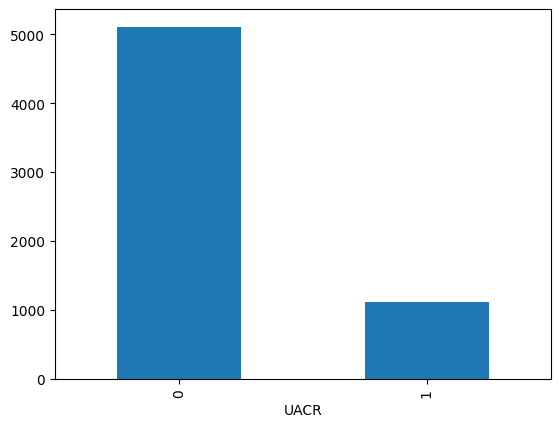

In [34]:
# It is an imbalanced dataset
df['UACR'].value_counts().plot(kind='bar')

In [35]:
# Split the data into features (X) and target (y)
X = df.drop("UACR", axis=1)
y = df["UACR"]


In [36]:
# function to standardize binary columns
def process_columns(df, column_names):
    for column_name in column_names:
        for i in range(df.shape[0]):
            if df.loc[i, column_name] < 0.5:
                df.loc[i, column_name] = 0
            else:
                df.loc[i, column_name] = 1

In [37]:
def test_trainsplit(X,y):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    #print(X.dtypes)
    
    #Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    binary_cols = ['Gender','Marital_status', 'Pregnant', 'current_drinker',
       'former_drinker_x', 'current_smoker', 'former_drinker_y', 'Aspirin_use',
       'High_Blood_pressure', 'High_Cholestrol', 'Chest_pain',
       'stomach problem', 'Chest Cold', 'Pneu_flu_ear infection', 'HIV',
       'Diabetes', 'Difficulty Hearing', 'Difficulty Seeing',
       'Hepatitis_B', 'Hepatitis_C', 'hospitalized','Weak Kidney','Kidney Stone',
       'Pesticide_used', 'anemia', 'overweight','blood_transfusion', 'arthritis', 'gout', 'congestive heart failure',
       'coronary heart disease', 'heart attack', 'stroke', 'emphysema','thyroid', 'chronic bronchitis',
        'liver problem', 'COPD', 'jaundice', 'cancer', 'kidney_cancer','Farmer', 'smoked_in_pregnancy',
        'Prescribed_medicine','HC2','HC3','HC4','HC5',
      'days_hospitalised_2','days_hospitalised_3','days_hospitalised_4','days_hospitalised_5','days_hospitalised_6']
    binary_features=[col for col in X_train.columns if col in binary_cols]
    numerical_features=[col for col in X_train.columns if col not in binary_features]

    
    # Create a ColumnTransformer
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bin', 'passthrough', binary_features)
    ])
   
        # Standardize the features
    #scaler = StandardScaler()
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    #y_train_series=pd.Series(y_train)
    #y_train_series.value_counts()
    return X_train, X_test, y_train, y_test 

##### Classifiers


In [38]:
def models(X_train,y_train,model):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    if model=='Logistic Regression':
        clf=LogisticRegression(C=10,penalty='l1',solver='liblinear')
    elif model== 'DT':
        clf=DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=5)
    elif model== 'SVM':
        clf=SVC(kernel='rbf',C=100)
    elif model== 'Random Forest':
        clf=RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=10)
    else:
        clf=KNeighborsClassifier(n_neighbors=5)
        
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    return y_pred
            
    

##### Evaluation Metrics

In [39]:
#Evaluation metrics
def metrics_calculation(y_actual, y_predicted,model,imp_method,samp_method,dim_reduc,plot_roc_curve=True):
    from sklearn import metrics
    #Classification report
    #class_report=metrics.classification_report(y_actual,y_predicted)
    #print("Classification report:\n",class_report)
    
    #Confusion Matrix
    conf_mat = metrics.confusion_matrix(y_actual,y_predicted,labels=None)
    #print("Confusion Matrix:\n",conf_mat)
    
    #Confusion Matrix Display
    #conf_display=metrics.ConfusionMatrixDisplay(conf_mat)
    #conf_display.plot()
    #plt.show()
    
    #Accuracy
    accuracy =metrics.accuracy_score(y_actual, y_predicted)
    #print("Accuracy:",accuracy)
    
    #precision
    precision=metrics.precision_score(y_actual, y_predicted)
    #print("Precision:",precision)
    
    #Recall
    recall=metrics.recall_score(y_actual, y_predicted)
    #print("Recall:",recall)

    #sensitivity
    sensitivity = conf_mat[1, 1] / (conf_mat[1,1] + conf_mat[1,0])
    #print("Sensitivity:",sensitivity)
    
    #specificity
    specificity = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])
    #print("Specificity:",specificity)
    
    #f1-score
    f1_score = metrics.f1_score(y_actual,y_predicted)
    #print("F1-Score:",f1_score)
    
    #Cohen's Kappa score
    Kappa_score= metrics.cohen_kappa_score(y_actual,y_predicted)
    #print("Cohen Kappa Score:",Kappa_score)
    
    #G-measure
    g_measure=2*(precision*recall)/(precision+recall)
    #print("G_measure:",g_measure)
    
    #Informedness/Youdens statistic
    informedness=sensitivity+specificity-1
    #print("Informedness/Youdens statistic:",informedness)
    
    #Positive predictive Value
    ppv= conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
    #print("PPV:",ppv)
    
     #Negative predictive Value
    npv= conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[1,0])
    #print("NPV:",npv)
    
    #Markedness
    marked=ppv+npv-1
    #print("Markedness:",marked)
    
    # Matthews Correlation Coefficient
    mcc=((conf_mat[0, 0] * conf_mat[1, 1]) - (conf_mat[0, 1] * conf_mat[1, 0]))/np.sqrt((conf_mat[0, 0] + conf_mat[0, 1])
        * (conf_mat[0, 0] + conf_mat[1, 0]) * (conf_mat[1, 1] + conf_mat[1, 0]) * (conf_mat[1, 1] + conf_mat[0, 1]))
    #print("Matthews Correlation Coefficient",mcc)
    
    #ROC-AUC Score
    roc_auc=metrics.roc_auc_score(y_actual,y_predicted)
    #print("ROC-AUC Score:",roc_auc)
    
    #ROC_Curve
    fpr,tpr,thresholds =metrics.roc_curve(y_actual,y_predicted)
    '''if plot_roc_curve:
        print('Classifier:',model)
        # Plot ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
      '''  
    results={'Model':model,"Imputation Method":imp_method,'Oversampling Method': samp_method,'Dimension reduction':dim_reduc,"Accuracy":accuracy,"Precision":precision,"Recall":recall,"F1-Score":f1_score,"ROC-AUC Score":roc_auc}
    #print(results)
    return results
  

##### Imputation Methods

In [40]:
#KNN
from sklearn.impute import KNNImputer
def impute_missing_values_knn(df, n_neighbors=3, weights='uniform', metric='nan_euclidean'):
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights, metric=metric)
    X_imputed = imputer.fit_transform(df)
    missing_count = np.sum(np.isnan(X_imputed).flatten())
    X_columns = df.iloc[:, :]  # Select all columns
    df_knn = pd.DataFrame(X_imputed, columns=X_columns.columns)
    return df_knn


In [41]:
#median
def fill_missing_with_median(df3):
    columns_with_missing_values = df.columns[df.isnull().any()].tolist()
    df_median = df3.copy()
    df_median[columns_with_missing_values] = df3[columns_with_missing_values].fillna(df3.median())
    return df_median

In [42]:
def diff_imputation_methods(df,imp_method):
    if imp_method=='constant':
        df_impute=df.fillna(37)
    elif imp_method=='knn':
        df_impute = impute_missing_values_knn(df)
        #print(X_selected)
    elif imp_method== 'median':
        # usage of select_k_best
        df_impute = fill_missing_with_median(df)
    elif imp_method== 'MICE':
        df_impute=impute_missing_data(df)
    return df_impute
            
    

In [43]:
#MICE
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def impute_missing_data(df, estimator_max_depth=8, random_state=11, skip_complete=True):
    estimator = RandomForestRegressor(max_depth=estimator_max_depth)
    mice = IterativeImputer(estimator=estimator, random_state=random_state, skip_complete=skip_complete)
    #print(mice)
    impdata = mice.fit_transform(df)
    print(impdata)
    impdata = pd.DataFrame(impdata, columns=df.columns)
    print(impdata.shape)
    total_missing = impdata.isnull().sum().sum()
    return impdata

##### Evaluating Imputation techniques

In [44]:
classifiers= ['Logistic Regression','SVM','DT','Random Forest','KNN']
imputation_methods = ['constant','knn', 'median']

#Imputation methods
eval_metrics=[]
for model in classifiers:
    for imp_method in imputation_methods:
        # Apply imputation methods
        X_imputed = diff_imputation_methods(X, imp_method)
        X_train, X_test, y_train, y_test=test_trainsplit(X_imputed,y)      
        y_pred=models(X_train, y_train,model)
        metrics=metrics_calculation(y_test,y_pred,model,imp_method,None,None)
        #eval_metrics[method]=metrics
        eval_metrics.append(metrics)
evaluation_df = pd.DataFrame(eval_metrics)
evaluation_df      


,Model,Imputation Method,Oversampling Method,Dimension reduction,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score
0,Logistic Regression,constant,None,None,0.809639,0.492537,0.139831,0.217822,0.553067
1,Logistic Regression,knn,None,None,0.828112,0.677419,0.177966,0.281879,0.579072
2,Logistic Regression,median,None,None,0.820080,0.603448,0.148305,0.238095,0.562755
3,SVM,constant,None,None,0.812851,1.000000,0.012712,0.025105,0.506356
4,SVM,knn,None,None,0.934137,0.892857,0.741525,0.810185,0.860356
5,SVM,median,None,None,0.938153,0.929730,0.728814,0.817102,0.857965
6,DT,constant,None,None,0.897992,0.870748,0.542373,0.668407,0.761771
7,DT,knn,None,None,0.893976,0.842105,0.542373,0.659794,0.759293
8,DT,median,None,None,0.890763,0.847222,0.516949,0.642105,0.747573
9,Random Forest,constant,None,None,0.902811,1.000000,0.487288,0.655271,0.743644


<Figure size 2000x1000 with 0 Axes>

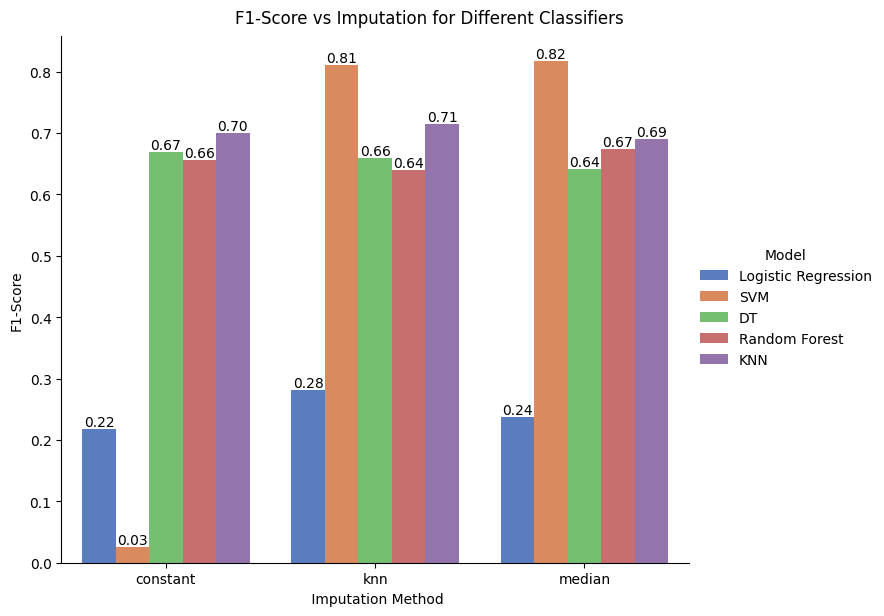

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'evaluation_df' is your DataFrame
# Replace 'Classifier', 'Oversampling Method', 'Dimension reduction', 'F1-Score' with your actual column names

# Set up the plot
plt.figure(figsize=(20, 10))

# Grouped bar plot using seaborn catplot
g=sns.catplot(
    x='Imputation Method',
    y='F1-Score',
    hue='Model',
    data=evaluation_df,
    kind='bar',
    height=6,  # Set the height of each facet
    aspect=1.2,  # Adjust the width of each facet
    ci=None,  # Disable error bars for clarity
    palette='muted',  # Choose a color palette
    dodge=True,  # Separate bars for each classifier within each oversampling method
)

# Customize the plot
g.fig.suptitle('F1-Score vs Imputation for Different Classifiers', y=1.02)
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.2f}',
                ha='center', va='bottom', color='black', fontsize=10)


plt.xlabel(' Imputation Method')
plt.ylabel('F1-Score')
#plt.legend(title='Classifier')

# Show the plot
plt.show()


#### Oversampling Techniques

In [46]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC

def oversample_data(X, y, method='smote', sampling_strategy='auto', random_state=42):
    if method == 'smote':
        oversampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    elif method == 'borderline':
        oversampler = BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    elif method == 'adasyn':
        oversampler = ADASYN(sampling_strategy=sampling_strategy, random_state=random_state)
    elif method == 'smotenc':
        categorical_features = [True] * X.shape[1]
        categorical_features[1] = False  # Age is not categorical
        oversampler = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=random_state)
    else:
        raise ValueError("Invalid oversampling method")

    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

##### Evaluating Oversampling Methods

In [47]:
classifiers= ['Logistic Regression','SVM','DT','Random Forest','KNN']
oversampling_methods = ['smote', 'borderline', 'adasyn','smotenc']

#Oversampling models
eval_metrics=[]
X_imputed = impute_missing_values_knn(X)
X_train, X_test, y_train, y_test=test_trainsplit(X_imputed,y)  
for model in classifiers:
    for samp_method in oversampling_methods:
        # Apply oversampling using the oversample_data function
        X_resampled, y_resampled = oversample_data(X_train, y_train, method=samp_method)
        y_pred=models(X_resampled, y_resampled,model)
        metrics=metrics_calculation(y_test,y_pred,model,'knn',samp_method,None)
        #eval_metrics[method]=metrics
        eval_metrics.append(metrics)
evaluation_df_over = pd.DataFrame(eval_metrics)
evaluation_df_over      


,Model,Imputation Method,Oversampling Method,Dimension reduction,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score
0,Logistic Regression,knn,smote,None,0.718072,0.360775,0.631356,0.459168,0.684855
1,Logistic Regression,knn,borderline,None,0.662651,0.304255,0.605932,0.405099,0.640924
2,Logistic Regression,knn,adasyn,None,0.637751,0.276507,0.563559,0.370990,0.609332
3,Logistic Regression,knn,smotenc,None,0.735743,0.381074,0.631356,0.475279,0.695757
4,SVM,knn,smote,None,0.918072,0.793860,0.766949,0.780172,0.860184
5,SVM,knn,borderline,None,0.915663,0.781116,0.771186,0.776119,0.860321
6,SVM,knn,adasyn,None,0.913253,0.773504,0.766949,0.770213,0.857211
7,SVM,knn,smotenc,None,0.905221,0.737903,0.775424,0.756198,0.855502
8,DT,knn,smote,None,0.867470,0.625442,0.750000,0.682081,0.822473
9,DT,knn,borderline,None,0.811245,0.501441,0.737288,0.596913,0.782916


<Figure size 2000x1000 with 0 Axes>

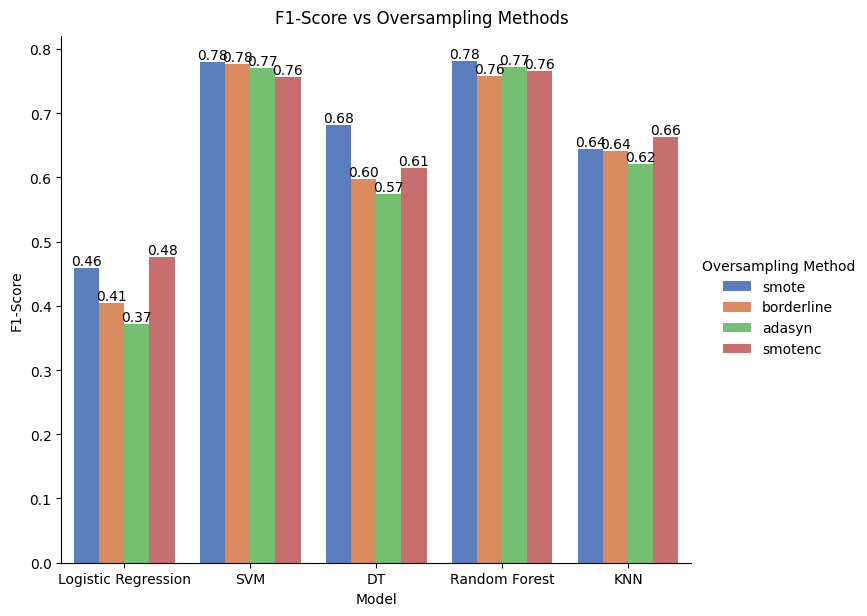

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'evaluation_df' is your DataFrame
# Replace 'Classifier', 'Oversampling Method', 'Dimension reduction', 'F1-Score' with your actual column names

# Set up the plot
plt.figure(figsize=(20, 10))

# Grouped bar plot using seaborn catplot
g=sns.catplot(
    x='Model',
    y='F1-Score',
    hue='Oversampling Method',
    data=evaluation_df_over,
    kind='bar',
    height=6,  # Set the height of each facet
    aspect=1.2,  # Adjust the width of each facet
    ci=None,  # Disable error bars for clarity
    palette='muted',  # Choose a color palette
    dodge=True,  # Separate bars for each classifier within each oversampling method
)

# Customize the plot
g.fig.suptitle('F1-Score vs Oversampling Methods', y=1.02)
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.2f}',
                ha='center', va='bottom', color='black', fontsize=10)
plt.xlabel('Model')
plt.ylabel('F1-Score')
#plt.legend(title='Classifier')

# Show the plot
plt.show()


##### Dimension Reduction techniques

In [49]:
import statsmodels.api as sm
# takes input - X(feature vector), y(target variable)
# prints significant columns with(p-value<0.05)
# outputs new dataframe with only significant features
# remove print statements when not needed
def get_p_values_significant_features(X,y):
    
    X = sm.add_constant(X)
    ols_model = sm.OLS(y, X).fit()
    p_features = {}
    for i in X.columns.tolist():
        p_features[f'{i}'] = ols_model.pvalues[i]

    data_pvalue= pd.DataFrame(p_features.items(), columns=['Feature_name', 'p-Value']).sort_values(by = 'p-Value').reset_index(drop=True)
    #print('*'*50
    
    
    
    #print('significant features')
    #print('*'*50)
    #print(data_pvalue[data_pvalue['p-Value']<0.05])
    significant_features = data_pvalue[data_pvalue['p-Value']<0.05]['Feature_name'].tolist()
    #print("significant_features:",X[significant_features].shape)
    
    return X[significant_features]



In [50]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# takes input - X(feature vector), y(target variable), no_of_features(to be selected)
# prints selected columns
# outputs new dataframe with selected features
# remove print statements when not needed
def select_k_best(X,y,no_of_features):
    k_selector = SelectKBest(mutual_info_classif, k=no_of_features)
    X_new = k_selector.fit_transform(X, y)
    chosen_indices = k_selector.get_support(indices=True)
    column_names = X.columns
    #print('*'*50)
    #print('selected features using mutual_info_classif')
    #print('*'*50)
    selected_column_names = column_names[chosen_indices]
    #print(selected_column_names)
    #print("SelKbest:",selected_column_names.shape)
    return X[selected_column_names]


In [51]:
#PCA
def kernelpca_dim_reduction(X):
    from sklearn.decomposition import KernelPCA
    # Apply PCA
    #n_components=0.95
    k_pca = KernelPCA(40, kernel='rbf')
    X_pca = k_pca.fit_transform(X)
    #print(X_pca.shape)
    return X_pca

In [52]:
def dimension_reduction(X,y,dim_red):
    if dim_red=='p-significant feature':
        X_selected = get_p_values_significant_features(X,y)
        #print(X_selected)
    elif dim_red== 'SelectKBest':
        # usage of select_k_best
        X_selected = select_k_best(X, y, 40)
    elif dim_red== 'kernelpca':
        X_selected=kernelpca_dim_reduction(X)
    return X_selected
            
    

In [55]:
dim_reduction= ['p-significant feature','SelectKBest']
classifiers= ['Logistic Regression','DT','Random Forest','KNN','SVM']
oversampling_methods = ['smote', 'borderline', 'adasyn']
# Standardize the features

eval_metrics=[]
X_imputed = impute_missing_values_knn(X)
for model in classifiers:
    for dim in dim_reduction:
        X_selected=dimension_reduction(X_imputed, y,dim)
        X_train, X_test, y_train, y_test=test_trainsplit(X_selected,y)
        #print(X_selected)
       #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        for samp_method in oversampling_methods:
            #X_train, X_test, y_train, y_test=test_trainsplit(X_imputed,y)  
            # Apply oversampling using the oversample_data function
            X_resampled, y_resampled = oversample_data(X_train, y_train, method=samp_method)
            #print(X_resampled.shape, y_resampled.shape)
            y_pred=models(X_resampled, y_resampled,model)
            #print(Y_pred.shape)
            metrics=metrics_calculation(y_test,y_pred,model,'knn',samp_method,dim)
            #eval_metrics[method]=metrics
            eval_metrics.append(metrics)
evaluation_df = pd.DataFrame(eval_metrics)
evaluation_df      



,Model,Imputation Method,Oversampling Method,Dimension reduction,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score
0,Logistic Regression,knn,smote,p-significant feature,0.723695,0.359375,0.584746,0.445161,0.670470
1,Logistic Regression,knn,borderline,p-significant feature,0.641767,0.283951,0.584746,0.382271,0.619925
2,Logistic Regression,knn,adasyn,p-significant feature,0.600803,0.265709,0.627119,0.373266,0.610883
3,Logistic Regression,knn,smote,SelectKBest,0.690763,0.332584,0.627119,0.434655,0.666384
4,Logistic Regression,knn,borderline,SelectKBest,0.620080,0.271676,0.597458,0.373510,0.611415
5,Logistic Regression,knn,adasyn,SelectKBest,0.575904,0.237410,0.559322,0.333333,0.569552
6,DT,knn,smote,p-significant feature,0.836948,0.555556,0.699153,0.619137,0.784165
7,DT,knn,borderline,p-significant feature,0.847390,0.582734,0.686441,0.630350,0.785738
8,DT,knn,adasyn,p-significant feature,0.772691,0.435262,0.669492,0.527546,0.733160
9,DT,knn,smote,SelectKBest,0.836145,0.554795,0.686441,0.613636,0.778800


<Figure size 2000x1000 with 0 Axes>

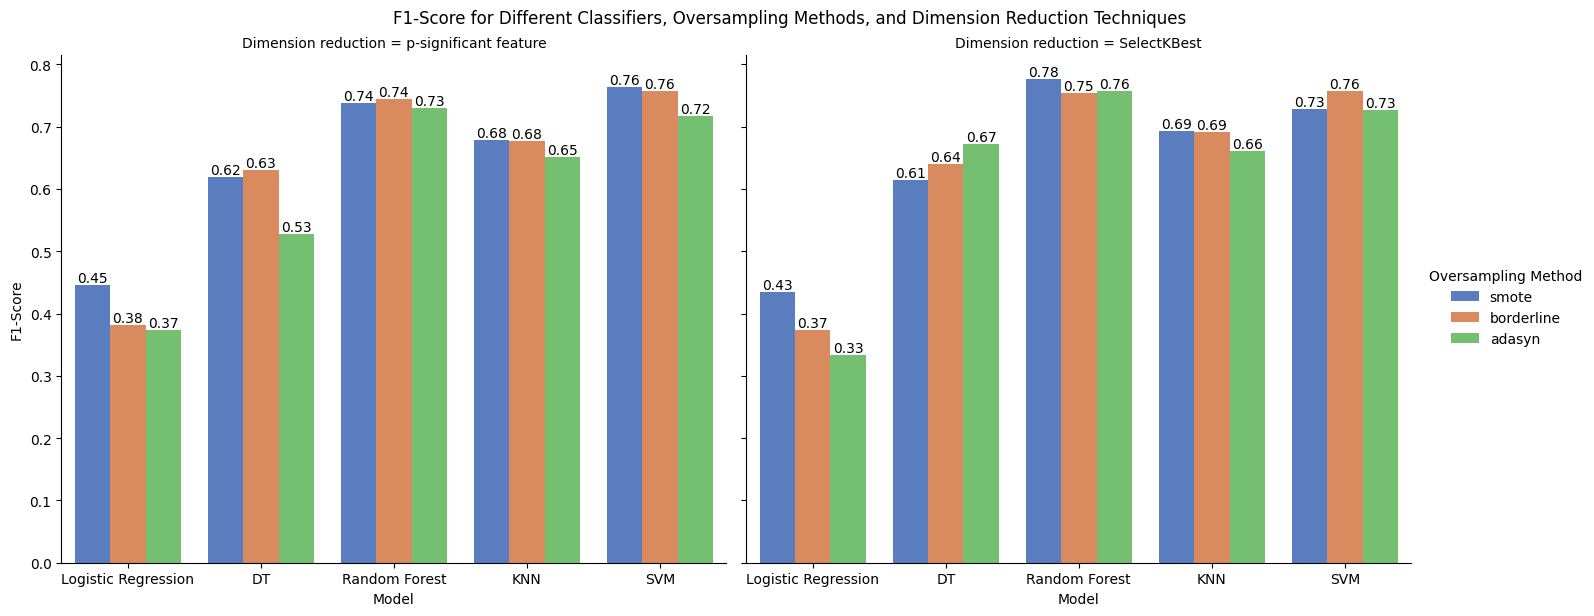

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'evaluation_df' is your DataFrame
# Replace 'Classifier', 'Oversampling Method', 'Dimension reduction', 'F1-Score' with your actual column names

# Set up the plot
plt.figure(figsize=(20, 10))

# Grouped bar plot using seaborn catplot
g=sns.catplot(
    x='Model',
    y='F1-Score',
    hue='Oversampling Method',
    col='Dimension reduction',
    data=evaluation_df,
    kind='bar',
    height=6,  # Set the height of each facet
    aspect=1.2,  # Adjust the width of each facet
    ci=None,  # Disable error bars for clarity
    palette='muted',  # Choose a color palette
    dodge=True,  # Separate bars for each classifier within each oversampling method
)

# Customize the plot
g.fig.suptitle('F1-Score for Different Classifiers, Oversampling Methods, and Dimension Reduction Techniques', y=1.02)
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.2f}',
                ha='center', va='bottom', color='black', fontsize=10)
plt.xlabel('Model')
plt.ylabel('F1-Score')
#plt.legend(title='Classifier')

# Show the plot
plt.show()


In [49]:
g.savefig('grouped_bar_plot.png', format='png', bbox_inches='tight')